In [1]:
import pandas as pd
import numpy as np

In [2]:
filepath = 'Ames_Housing_Sales.csv'
data = pd.read_csv(filepath, sep=',')

print(data.shape)

(1379, 80)


In [3]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,856.0,854.0,0.0,None,3,1Fam,TA,No,706.0,0.0,...,0.0,Pave,8,856.0,AllPub,0.0,2003,2003,2008,208500.0
1,1262.0,0.0,0.0,None,3,1Fam,TA,Gd,978.0,0.0,...,0.0,Pave,6,1262.0,AllPub,298.0,1976,1976,2007,181500.0
2,920.0,866.0,0.0,None,3,1Fam,TA,Mn,486.0,0.0,...,0.0,Pave,6,920.0,AllPub,0.0,2001,2002,2008,223500.0
3,961.0,756.0,0.0,None,3,1Fam,Gd,No,216.0,0.0,...,0.0,Pave,7,756.0,AllPub,0.0,1915,1970,2006,140000.0
4,1145.0,1053.0,0.0,None,4,1Fam,TA,Av,655.0,0.0,...,0.0,Pave,9,1145.0,AllPub,192.0,2000,2000,2008,250000.0


In [4]:
# To examine a data type 

data.dtypes.value_counts()

object     43
float64    21
int64      16
dtype: int64

In [5]:
# Select the object (string) columns 

mask=data.dtypes==np.object
categorical_cols=data.columns[mask]

In [6]:
# Determine how many extra columns would be created 

num_ohc_cols=(data[categorical_cols]
              .apply(lambda x : x.nunique())
              .sort_values(ascending=False))

In [7]:
#No need to encode if there is only one value

small_num_ohc_cols=num_ohc_cols.loc[num_ohc_cols>1]

In [8]:
# No. of one hot columns is less than the number of category

small_num_ohc_cols-=1

In [9]:
# this is quite a frw extra columns !
small_num_ohc_cols.sum()

215

In [10]:
# Creation of a new dataset categorical fearures will be one hot encoded 

from sklearn.preprocessing import OneHotEncoder,LabelEncoder

In [11]:
data_ohc=data.copy()

In [12]:
# The Encoders 

le=LabelEncoder()
ohc=OneHotEncoder()

for col in num_ohc_cols.index:
    #Integer encode the string catrgories
    dat=le.fit_transform(data_ohc[col]).astype(np.int)
    
    #Removal of original column from dataframe 
    data_ohc=data_ohc.drop(col,axis=1)
    
    #one hot encode the data returns sparse array
    new_dat=ohc.fit_transform(dat.reshape(-1,1))
    
    #create unique column names 
    n_cols=new_dat.shape[1]
    cols_names=['_'.join([col,str(x)]) for x in range(n_cols)]
    
    #create the new dataframe 
    new_df=pd.DataFrame(new_dat.toarray(),index=data_ohc.index,columns=cols_names)
    
    #append the new data to dataframe 
    data_ohc=pd.concat([data_ohc,new_df],axis=1)
    
    

In [13]:
#column differencr is also calculated above 

data_ohc.shape[1]-data.shape[1]

215

In [14]:
print(data.shape[1])

80


In [15]:
data=data.drop(num_ohc_cols.index,axis=1)
print(data.shape[1])

37


In [16]:
# create train and test split of both the data


In [17]:
from sklearn.model_selection import train_test_split

y_col='SalePrice'

#Split the data that is not one hot encoded

feature_cols=[x for x in data.columns if x!= y_col]

X_data=data[feature_cols]

y_data=data[y_col]

X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,test_size=0.3,random_state=42)

# split the data that is one hot encoded

feature_cols=[x for x in data_ohc.columns if x!= y_col]

X_data_ohc=data_ohc[feature_cols]

y_data_ohc=data_ohc[feature_cols]

X_train_ohc,X_test_ohc,y_train_ohc,y_test_ohc=train_test_split(X_data_ohc,y_data_ohc,test_size=0.3,random_state=42)


In [18]:
#compare the indices to ensure they are identical 

(X_train_ohc.index==X_train.index).all()

True

In [19]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

LR=LinearRegression()

#storage for error values

error_df=list()

#Data that have not been one hot encoded

LR=LR.fit(X_train,y_train)
y_train_pred=LR.predict(X_train)
y_test_pred=LR.predict(X_test)
error_df.append(pd.Series({'train':mean_squared_error(y_train,y_train_pred),
                           'test':mean_squared_error(y_test,y_test_pred)},
                          name='no enc'))

#Data that have been one hot encoded 

LR=LR.fit(X_train_ohc,y_train_ohc)
y_train_ohc_pred=LR.predict(X_train_ohc)
y_test_ohc_pred=LR.predict(X_test_ohc)
error_df.append(pd.Series({'train':mean_squared_error(y_train_ohc,y_train_ohc_pred),
                           'test':mean_squared_error(y_test_ohc,y_test_ohc_pred)},
                          name='one-hot enc'))

#Assemble the results 
error_df=pd.concat(error_df,axis=1)
error_df

,no enc,one-hot enc
train,1.131507e+09,2.145020e-23
test,1.372182e+09,1.559598e-04


In [20]:
#mute the settings with a copy warnings

pd.options.mode.chained_assignment=None


In [21]:

from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler

scalers={'standard':StandardScaler(),
         'minmax':MinMaxScaler(),
         'maxabs':MaxAbsScaler()}

training_test_sets={'not_encoded':(X_train,y_train,X_test,y_test),
                    'one_hot_encoded':(X_train_ohc,y_train_ohc,X_test_ohc,y_test_ohc)}

mask=X_train.dtypes==np.float

float_columns=X_train.columns[mask]

#initialize model

LR=LinearRegression()

#iterate over all possible combinations ans get all the errors

errors={}

for encoding_label,(_X_train,_y_train,_X_test,_y_test) in training_test_sets.items():
    
    for scaler_label,scaler in scalers.items():
        
        trainingset=_X_train.copy()
        testset=_X_test.copy()
        trainingset[float_columns]=scaler.fit_transform(trainingset[float_columns])
        testset[float_columns]=scaler.fit_transform(testset[float_columns])
        LR.fit(trainingset,_y_train)
        predictions=LR.predict(testset)
        key=encoding_label+'-'+scaler_label+'scaling'
        errors[key]=mean_squared_error(_y_test,predictions)
        
errors=pd.Series(errors)
print(errors.to_string())

print('-'*80)

for key,error_val in errors.items():
    print(key,error_val)

not_encoded-standardscaling        1.368112e+09
not_encoded-minmaxscaling          4.134416e+29
not_encoded-maxabsscaling          8.525267e+29
one_hot_encoded-standardscaling    1.153591e+05
one_hot_encoded-minmaxscaling      3.514367e+06
one_hot_encoded-maxabsscaling      4.331993e+06
--------------------------------------------------------------------------------
not_encoded-standardscaling 1368112344.8337972
not_encoded-minmaxscaling 4.134415517655748e+29
not_encoded-maxabsscaling 8.525267089724106e+29
one_hot_encoded-standardscaling 115359.12355292584
one_hot_encoded-minmaxscaling 3514367.3462220463
one_hot_encoded-maxabsscaling 4331993.064948273


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

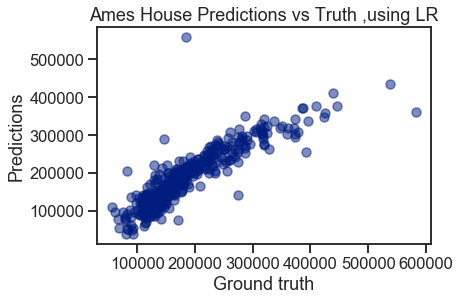

In [24]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax=plt.axes()

ax.scatter(y_test,y_test_pred,alpha=.5)

ax.set(xlabel='Ground truth',
       ylabel='Predictions',
       title='Ames House Predictions vs Truth ,using LR');